In [1]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

GCP_PROJECT = 'opensource-observer'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../oso_gcp_credentials.json'
client = bigquery.Client(GCP_PROJECT)

In [2]:
query = """
    with txns as (
      select
        chain,
        to_address,
        round(gas * gas_price / 1e18, 6) as gas_fee
      from `optimism_superchain_raw_onchain_data.transactions`
      where
          dt > '2024-12-01'
          and receipt_status = 1
          and gas * gas_price > 0
          and chain in (
              'mode',
              'op',
              'base',
              'zora'
            )
    )

    select
      txns.chain,
      abp.project_name,
      txns.gas_fee,
      count(*) as num_txns
    from txns
    inner join `oso_production.artifacts_by_project_v1` abp
        on txns.to_address = abp.artifact_name
    group by 1,2,3
    order by 1
"""

result = client.query(query)
df = result.to_dataframe()

In [3]:
df["percent_txns"] = df.groupby("chain")["num_txns"].transform(lambda x: x / x.sum() * 100)
df["gas_fee_gwei"] = df["gas_fee"] * 1e9
df.tail()

,chain,project_name,gas_fee,num_txns,percent_txns,gas_fee_gwei
102078,zora,rabbithole,0.000271,8,0.000134,271000.0
102079,zora,multicall-mds1,0.000276,3,0.00005,276000.0
102080,zora,nfts2me,0.000047,2,0.000034,47000.0
102081,zora,nfts2me,0.000027,12,0.000202,27000.0
102082,zora,nfts2me,0.000037,4,0.000067,37000.0


In [4]:
GAS_CAP = 0.03 / 3000

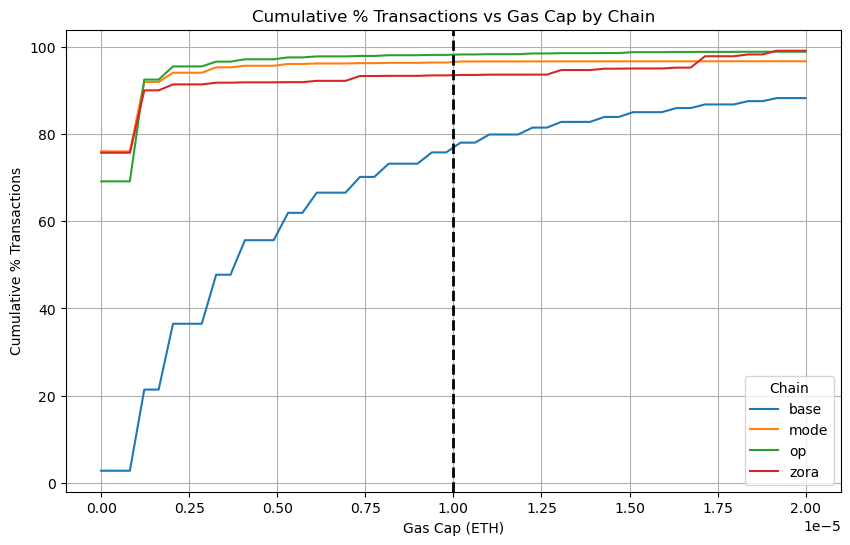

In [5]:
# Create a range of gas caps
gas_caps = np.linspace(0, GAS_CAP * 2, 50)

# Create an empty DataFrame to store results
results = []

# Vectorized calculation
for g in gas_caps:
    filtered = df[df["gas_fee"] <= g].groupby("chain")["percent_txns"].sum()
    results.append(filtered)

# Convert results to a DataFrame
results_df = pd.DataFrame(results, index=gas_caps).fillna(0)
results_df.index.name = "gas_cap"

# Plotting
plt.figure(figsize=(10, 6))
for chain in results_df.columns:
    plt.plot(results_df.index, results_df[chain], label=chain)

plt.axvline(GAS_CAP, color='black', lw=2, ls='--')    
    
plt.xlabel("Gas Cap (ETH)")
plt.ylabel("Cumulative % Transactions")
plt.title("Cumulative % Transactions vs Gas Cap by Chain")
plt.legend(title="Chain")
plt.grid(True)
plt.show()

In [6]:
total_txns_by_project = df.groupby("project_name")["num_txns"].sum()
above_threshold_txns = df[df["gas_fee"] > GAS_CAP].groupby("project_name")["num_txns"].sum()
percent_above_threshold = (above_threshold_txns / total_txns_by_project) * 100
percent_above_threshold = percent_above_threshold.fillna(0)
percent_above_threshold.sort_values().tail(30)

project_name
batchmoney-amazingang    56.632653
paraswap                  58.67823
gainsnetwork             59.217757
summer-fi                59.807956
avantis-labs             60.629502
0xproject                60.649905
daimo-eth                61.057692
gammastrategies          62.740702
portals-fi               63.699248
pancakeswap              65.705356
kairosresearch           66.666667
aktionariat              67.058824
bond-protocol             70.73955
pendle-finance           71.149224
bitkeep                  71.569074
poppunk-llc              78.123758
0xsequence               79.621849
bsx-exchange             81.202878
jojoexchange             85.756072
dolomite-exchange        86.666667
metamask                 87.274526
jones-dao                88.235294
rarible                  88.746896
symm-io                  89.021956
dinngo                   89.115646
powerpool-finance        90.072639
dexfinance-com           91.765075
hyperlane-xyz            98.467982
opensen